In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
dataframe = pd.read_csv('train.csv').as_matrix()

C:\Users\prince.yadav\AppData\Local\Continuum\miniconda3\envs\semantic\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [3]:
dataframe.shape

(42000, 785)

In [4]:
y, X = dataframe[:,0], dataframe[:, 1:]
y = y.reshape([-1,1])

indices = list(range(len(X)))
np.random.shuffle(indices)

X = X[indices].astype(np.float32)
y = y[indices].astype(np.float32)

In [5]:
# Split it into train and validation
n_train = int(0.7 * len(y))

y_train, X_train, y_test, X_test = y[: n_train], X[: n_train, :], y[n_train:], X[n_train:, :]

X_train -= 127.0
X_train /= 127.0

X_test  -= 127.0
X_test /= 127.0

In [6]:
## Creating a batches of images

def get_next_batch(batch_size, X, y):
    for i in range(0, len(y), batch_size):
        start = i
        end = min(len(y), i+batch_size)
        
        ## in case of yield for loop will be stuck at place from where function terminated. 
        ## If we will not use yield for loop will start from 0 again when function is get called
        yield X[start: start+batch_size, :] , y[start: start+batch_size]

In [7]:
def combine(tensor_one, tensor_two):
    return tf.div(tf.add(tensor_one, tensor_two), 2)

In [8]:
input_ = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1]))
labels = tf.placeholder(dtype=tf.int32, shape=(None, 1))
learning_rate_ph = tf.placeholder(dtype=tf.float32)
keep_prob = tf.placeholder(dtype=tf.float32)

In [9]:
def nn():
    input_2d = tf.reshape(input_,[-1,28,28,1])
    l1_1 = tf.layers.conv2d(input_2d,8,5,1,activation=tf.nn.relu)
    l1_2 = tf.layers.average_pooling2d(l1_1,2,1)
    l1_3 = tf.layers.conv2d(l1_2,8,3,1,activation=tf.nn.relu)
    l1_4 = tf.layers.max_pooling2d(l1_3,2,2)
    l1_5 = tf.layers.flatten(l1_4)
    l2   = tf.layers.dense(l1_5, 32, activation=tf.nn.relu)
    out  = tf.layers.dense(l2,10)
    
    # Define the cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=tf.one_hot(labels,depth=10)))
    
    # Apply an optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_ph).minimize(cost)
    
    return cost, optimizer, out

In [10]:
cost, optimizer, output = nn()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

epochs = 75
batch_size = 512
num_batches = int(X_train.shape[0]/batch_size)
n_train = int(len(y_train)*0.8)

train_accuracy = []
val_accuracy = []
test_accuracy = []
cost_curr = []

def eval_cost(X, y):
    total_cost = 0
    nb_batches = 0
    for X,y in get_next_batch(256,X,y):
        feed_dict={input_: X, labels: y, learning_rate_ph:current_placeholder_value, keep_prob:1.0}
        total_cost += cost.eval(feed_dict=feed_dict)
        nb_batches += 1
    return total_cost / nb_batches

def eval_accuracy(X,y):
    nb_batches = 0
    total_acc = 0
    for X,y in get_next_batch(256,X,y):
        feed_dict={input_: X, labels: y, learning_rate_ph:current_placeholder_value, keep_prob:1.0}
        y_predicted = np.argmax(output.eval(feed_dict=feed_dict),1)
        total_acc += accuracy_score(y,y_predicted)
        nb_batches += 1
    return total_acc/nb_batches
        

# Launch the graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    current_placeholder_value = 0.001
    
    for epoch in tqdm(range(epochs)):
        # Shuffle data for cross validation
        indices = np.array(range(len(y_train)))
        np.random.shuffle(indices)
        
        train_indices = indices[: n_train]
        val_indices = indices[n_train:]
        
        print('train indices', len(train_indices), 'val indices', len(val_indices))
        
        y_train_fold, X_train_fold, y_val_fold, X_val_fold = y_train[train_indices], X_train[train_indices, :], \
        y_train[val_indices], X_train[val_indices, :]
        
        # Loop over all batches
        for x,y in get_next_batch(batch_size, X_train_fold, y_train_fold):
            sess.run(optimizer, 
                     feed_dict={input_:x, labels:y, learning_rate_ph:current_placeholder_value, keep_prob:0.70})
        
        
        if (epoch+1) % 1 == 0:
            # Find training cost.
            c = eval_cost(X_train_fold, y_train_fold)
            cost_curr.append(c)
            # Find train accuracy
            current_train_acc = eval_accuracy(X_train_fold,y_train_fold)
            train_accuracy.append(current_train_acc)
            # Find the validation accuracy
            current_val_acc = eval_accuracy(X_val_fold, y_val_fold)
            val_accuracy.append(current_val_acc)
            # Find test accuracy
            test_acc = eval_accuracy(X_test, y_test)
            test_accuracy.append(test_acc)
            
            
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            print("Train Accuracy:", current_train_acc)
            print("Validation Accuracy:", current_val_acc)
            print("Test Accuracy:",test_acc)
            print()
            
            if test_acc > 0.99:
                saver = tf.train.Saver()
                saver.save(sess,'./mnist-acc{}'.format(test_acc*100.0),global_step=epoch+1)
              
    
    print("Optimization Finished!")
    # Find test accuracy
    print("Test Accuracy:",eval_accuracy(X_test, y_test) )
    
    tf.train.write_graph(
   tf.get_default_graph().as_graph_def(),
   './graphs/',
   'mnist.pbtxt',
   as_text=True)
    
    tf.train.write_graph(
    tf.get_default_graph().as_graph_def(),
    './graphs/',
    'mnist.pb',
    as_text=False
    )
    
    


  0%|                                                                                                                                           | 0/75 [00:00<?, ?it/s]

train indices 23519 val indices 5880
Epoch: 0001 cost= 0.450943963
Train Accuracy: 0.8713863950697017
Validation Accuracy: 0.8673682941795231
Test Accuracy: 0.8706304824561404



  1%|█▋                                                                                                                                 | 1/75 [00:37<46:01, 37.32s/it]

train indices 23519 val indices 5880
Epoch: 0002 cost= 0.212848010
Train Accuracy: 0.9371934557174889
Validation Accuracy: 0.9327993513323982
Test Accuracy: 0.9356277412280701



  3%|███▍                                                                                                                               | 2/75 [01:13<44:42, 36.75s/it]

train indices 23519 val indices 5880
Epoch: 0003 cost= 0.156486082
Train Accuracy: 0.9530857775638526
Validation Accuracy: 0.9515416812762973
Test Accuracy: 0.9499232456140351



  4%|█████▏                                                                                                                             | 3/75 [01:51<44:39, 37.22s/it]

train indices 23519 val indices 5880
Epoch: 0004 cost= 0.135224029
Train Accuracy: 0.9603226978333983
Validation Accuracy: 0.9605594758064516
Test Accuracy: 0.9570723684210526



  5%|██████▉                                                                                                                            | 4/75 [02:31<44:48, 37.87s/it]

train indices 23519 val indices 5880
Epoch: 0005 cost= 0.104691284
Train Accuracy: 0.9685535070189121
Validation Accuracy: 0.9654683117110799
Test Accuracy: 0.965938870614035



  7%|████████▋                                                                                                                          | 5/75 [03:10<44:24, 38.06s/it]

train indices 23519 val indices 5880
Epoch: 0006 cost= 0.088875108
Train Accuracy: 0.9737775166333593
Validation Accuracy: 0.9695663131136045
Test Accuracy: 0.969376370614035



  8%|██████████▍                                                                                                                        | 6/75 [03:47<43:32, 37.86s/it]

train indices 23519 val indices 5880
Epoch: 0007 cost= 0.081723977
Train Accuracy: 0.9745528261478845
Validation Accuracy: 0.9739820739831697
Test Accuracy: 0.9711334978070175



  9%|████████████▏                                                                                                                      | 7/75 [04:24<42:46, 37.75s/it]

train indices 23519 val indices 5880
Epoch: 0008 cost= 0.072133922
Train Accuracy: 0.9788789085348021
Validation Accuracy: 0.9777020511921459
Test Accuracy: 0.9747272478070176



 11%|█████████████▉                                                                                                                     | 8/75 [05:02<42:14, 37.82s/it]

train indices 23519 val indices 5880
Epoch: 0009 cost= 0.065009378
Train Accuracy: 0.9806008877217781
Validation Accuracy: 0.9792634554698457
Test Accuracy: 0.9746491228070175



 12%|███████████████▋                                                                                                                   | 9/75 [05:42<41:49, 38.02s/it]

train indices 23519 val indices 5880
Epoch: 0010 cost= 0.063846380
Train Accuracy: 0.980588321310197
Validation Accuracy: 0.9797674877279102
Test Accuracy: 0.9750397478070175



 13%|█████████████████▎                                                                                                                | 10/75 [06:19<41:07, 37.96s/it]

train indices 23519 val indices 5880
Epoch: 0011 cost= 0.055937660
Train Accuracy: 0.9821545531536361
Validation Accuracy: 0.9794113779803647
Test Accuracy: 0.9751178728070176



 15%|███████████████████                                                                                                               | 11/75 [06:55<40:19, 37.81s/it]

train indices 23519 val indices 5880
Epoch: 0012 cost= 0.056632703
Train Accuracy: 0.9829424290797427
Validation Accuracy: 0.9807700736325387
Test Accuracy: 0.9747272478070176



 16%|████████████████████▊                                                                                                             | 12/75 [07:32<39:36, 37.72s/it]

train indices 23519 val indices 5880
Epoch: 0013 cost= 0.051833744
Train Accuracy: 0.9846046226116202
Validation Accuracy: 0.9836792163394109
Test Accuracy: 0.9768366228070176



 17%|██████████████████████▌                                                                                                           | 13/75 [08:10<39:00, 37.75s/it]

train indices 23519 val indices 5880
Epoch: 0014 cost= 0.048576314
Train Accuracy: 0.9855073098435367
Validation Accuracy: 0.9841777699859747
Test Accuracy: 0.9791022478070175



 19%|████████████████████████▎                                                                                                         | 14/75 [08:46<38:15, 37.64s/it]

train indices 23519 val indices 5880
Epoch: 0015 cost= 0.042540048
Train Accuracy: 0.9873770395666795
Validation Accuracy: 0.9882538569424966
Test Accuracy: 0.9784772478070175



 20%|██████████████████████████                                                                                                        | 15/75 [09:23<37:34, 37.58s/it]

train indices 23519 val indices 5880
Epoch: 0016 cost= 0.037490313
Train Accuracy: 0.9899607699478455
Validation Accuracy: 0.9852077489481066
Test Accuracy: 0.9796491228070175



 21%|███████████████████████████▋                                                                                                      | 16/75 [10:02<37:02, 37.67s/it]

train indices 23519 val indices 5880
Epoch: 0017 cost= 0.038481005
Train Accuracy: 0.9883410356550985
Validation Accuracy: 0.9884401297335204
Test Accuracy: 0.9801178728070176



 23%|█████████████████████████████▍                                                                                                    | 17/75 [10:39<36:20, 37.59s/it]

train indices 23519 val indices 5880
Epoch: 0018 cost= 0.036796506
Train Accuracy: 0.9897909329913238
Validation Accuracy: 0.9894427156381487
Test Accuracy: 0.9804303728070175



 24%|███████████████████████████████▏                                                                                                  | 18/75 [11:15<35:40, 37.55s/it]

train indices 23519 val indices 5880
Epoch: 0019 cost= 0.034516606
Train Accuracy: 0.9895849200014623
Validation Accuracy: 0.9889496406030855
Test Accuracy: 0.9788678728070175



 25%|████████████████████████████████▉                                                                                                 | 19/75 [11:52<35:01, 37.52s/it]

train indices 23519 val indices 5880
Epoch: 0020 cost= 0.032911885
Train Accuracy: 0.9907438858695652
Validation Accuracy: 0.9884236938990183
Test Accuracy: 0.9792584978070176



 27%|██████████████████████████████████▋                                                                                               | 20/75 [12:29<34:22, 37.49s/it]

train indices 23519 val indices 5880
Epoch: 0021 cost= 0.029213598
Train Accuracy: 0.9914531265232014
Validation Accuracy: 0.9891139989481066
Test Accuracy: 0.9798053728070175



 28%|████████████████████████████████████▍                                                                                             | 21/75 [13:06<33:41, 37.43s/it]

train indices 23519 val indices 5880
Epoch: 0022 cost= 0.028195522
Train Accuracy: 0.9922724184782609
Validation Accuracy: 0.9901384992987378
Test Accuracy: 0.9809772478070176



 29%|██████████████████████████████████████▏                                                                                           | 22/75 [13:42<33:00, 37.37s/it]

train indices 23519 val indices 5880
Epoch: 0023 cost= 0.026265420
Train Accuracy: 0.992635702013063
Validation Accuracy: 0.9913109221598878
Test Accuracy: 0.9807428728070176



 31%|███████████████████████████████████████▊                                                                                          | 23/75 [14:18<32:21, 37.34s/it]

train indices 23519 val indices 5880
Epoch: 0024 cost= 0.024384619
Train Accuracy: 0.9929517663043478
Validation Accuracy: 0.9915026735624124
Test Accuracy: 0.9813678728070175



 32%|█████████████████████████████████████████▌                                                                                        | 24/75 [14:55<31:43, 37.32s/it]

train indices 23519 val indices 5880
Epoch: 0025 cost= 0.025424959
Train Accuracy: 0.9928243885869565
Validation Accuracy: 0.9933708800841515
Test Accuracy: 0.9808991228070175



 33%|███████████████████████████████████████████▎                                                                                      | 25/75 [15:32<31:04, 37.29s/it]

train indices 23519 val indices 5880
Epoch: 0026 cost= 0.022417882
Train Accuracy: 0.9938308439145057
Validation Accuracy: 0.9914917163394109
Test Accuracy: 0.9812116228070176



 35%|█████████████████████████████████████████████                                                                                     | 26/75 [16:10<30:29, 37.33s/it]

train indices 23519 val indices 5880
Epoch: 0027 cost= 0.024987273
Train Accuracy: 0.9922598520666795
Validation Accuracy: 0.9915081521739131
Test Accuracy: 0.9802741228070175



 36%|██████████████████████████████████████████████▊                                                                                   | 27/75 [16:49<29:55, 37.40s/it]

train indices 23519 val indices 5880
Epoch: 0028 cost= 0.020216405
Train Accuracy: 0.9943104619565217
Validation Accuracy: 0.992351858345021
Test Accuracy: 0.9814459978070176



 37%|████████████████████████████████████████████████▌                                                                                 | 28/75 [17:27<29:17, 37.40s/it]

train indices 23519 val indices 5880
Epoch: 0029 cost= 0.026267300
Train Accuracy: 0.9915380450014623
Validation Accuracy: 0.9881004558204769
Test Accuracy: 0.979141995614035



 39%|██████████████████████████████████████████████████▎                                                                               | 29/75 [18:05<28:41, 37.42s/it]

train indices 23519 val indices 5880
Epoch: 0030 cost= 0.021051906
Train Accuracy: 0.9932489809782609
Validation Accuracy: 0.9901494565217391
Test Accuracy: 0.9799616228070175



 40%|████████████████████████████████████████████████████                                                                              | 30/75 [18:41<28:02, 37.39s/it]

train indices 23519 val indices 5880
Epoch: 0031 cost= 0.016557873
Train Accuracy: 0.9952382820116007
Validation Accuracy: 0.9947295757363254
Test Accuracy: 0.9820709978070176



 41%|█████████████████████████████████████████████████████▋                                                                            | 31/75 [19:20<27:27, 37.44s/it]

train indices 23519 val indices 5880
Epoch: 0032 cost= 0.015916840
Train Accuracy: 0.9954804710348021
Validation Accuracy: 0.9950637710378681
Test Accuracy: 0.9823053728070176



 43%|███████████████████████████████████████████████████████▍                                                                          | 32/75 [19:59<26:52, 37.50s/it]

train indices 23519 val indices 5880
Epoch: 0033 cost= 0.014961477
Train Accuracy: 0.99620856130581
Validation Accuracy: 0.9938584765077139
Test Accuracy: 0.9813678728070175



 44%|█████████████████████████████████████████████████████████▏                                                                        | 33/75 [20:38<26:15, 37.52s/it]

train indices 23519 val indices 5880
Epoch: 0034 cost= 0.014452199
Train Accuracy: 0.9965969776637746
Validation Accuracy: 0.9952336079943899
Test Accuracy: 0.9819928728070175



 45%|██████████████████████████████████████████████████████████▉                                                                       | 34/75 [21:14<25:36, 37.48s/it]

train indices 23519 val indices 5880


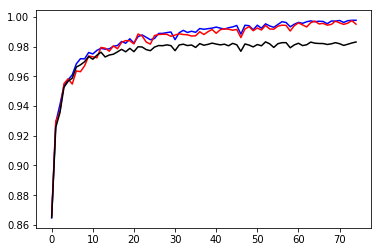

In [15]:
plt.plot(train_accuracy, 'b-', val_accuracy, 'r-', test_accuracy,'k-')
plt.show()

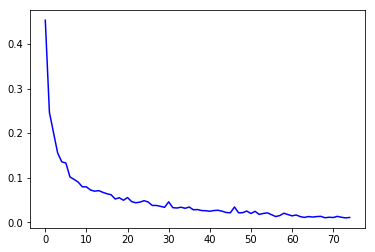

In [16]:
plt.plot(cost_curr, 'b-')
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=y_test, y_pred=y_predicted_test)

NameError: name 'y_predicted_test' is not defined

In [18]:
indices = np.where(np.logical_and(y_predicted_test == 7, y_test.squeeze() == 9))[0]
for i in indices:
    plt.figure(figsize=(0.50,0.50))
    plt.imshow(X_test[i].reshape([28,28]),cmap='gray')
    plt.show()

NameError: name 'y_predicted_test' is not defined